<a href="https://colab.research.google.com/github/JericCantos/CarsEDA/blob/main/Exploratory_Data_Analysis_Cars_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from io import StringIO
from scipy.stats import chi2_contingency
import numpy as np

# Loading the Dataset and check head

In [ ]:
file_id = "19V7VjHs4J8idTko7NQUT95ZJO2ZQSGWh"
download_url = f"https://drive.google.com/uc?export=download&id={file_id}"

response = requests.get(download_url)
if response.status_code == 200:
    csv_data = StringIO(response.text)
    df = pd.read_csv(csv_data)
    df.head()
else:
    print("Failed to download the file.")

# Check Shape and Data Types

In [ ]:
df.shape

(11914, 16)

In [ ]:
df.dtypes

,0
Make,object
Model,object
Year,int64
Engine Fuel Type,object
Engine HP,float64
Engine Cylinders,float64
Transmission Type,object
Driven_Wheels,object
Number of Doors,float64
Market Category,object


*Numeric values* seem to be assigned ok, however we need to be wary of all the int64 items if we're going to do operations with them. The Ratio items like Highway and City MPG might be better represented as floats.

# Handle Null Values and Duplicates


## Count Null Values per Column

In [ ]:
df.isnull().sum()

,0
Make,0
Model,0
Year,0
Engine Fuel Type,3
Engine HP,69
Engine Cylinders,30
Transmission Type,0
Driven_Wheels,0
Number of Doors,6
Market Category,3742


Out of 11914 Rows, there are 3742 Missing Market Category Entries (31.4%). That seems to be too high to simply drop all of the rows. We must impute using Mode given that this is categorical data.

The rest of the nulls constitute less than 1% of the dataset. I believe we can simply drop them.

## Standardize Text Columns

In [ ]:
# convert "Vehicle Style" and "Market Category" to lower case
# do this before imputation of Market Category so we are sure the correct mode is calculated
df["Market Category"] = df["Market Category"].str.strip().str.lower()
df["Vehicle Style"] = df["Vehicle Style"].str.strip().str.lower()

## Drop the Duplicates to have a clean dataset

In [ ]:
# do this before imputation of market category so we are sure correct mode is calculated
df = df.drop_duplicates()
df.shape

(11199, 16)

It seems like a lot of duplicates were dropped (from 11914 rows to 11199 rows)

## Impute Market Category by Mode

In [ ]:
mode_market_category = df["Market Category"].mode()[0]
print("Most frequent category:", mode_market_category)
df.loc[:,"Market Category"] = df["Market Category"].fillna(mode_market_category)

Most frequent category: crossover


## Drop empty rows for other columns

In [ ]:
dfcopy = df.dropna(axis=0)

#look at dfcopy shape to see if only a few rows were deleted
print (dfcopy.shape, df.shape)
print('rows lost:', len(df)-len(dfcopy))

(11097, 16) (11199, 16)
rows lost: 102


In [ ]:
# check if our backup copy now has zero nulls
dfcopy.isnull().sum()

,0
Make,0
Model,0
Year,0
Engine Fuel Type,0
Engine HP,0
Engine Cylinders,0
Transmission Type,0
Driven_Wheels,0
Number of Doors,0
Market Category,0


our backup copy of the dataset has been cleaned, and only a few rows were deleted as expected. we are now relatively safe to overwrite our dataframe with it.

In [ ]:
df = dfcopy

# Filter the data (Year >= 1995)

In [ ]:
#filtered_df is now my working dataset as I did not want to overwrite
#the df "original" so I can roll back if I made a mistake
filtered_df = df.loc[(df['Year']>=1995)]
filtered_df.shape

(10503, 16)

# Feature Engineering

## Create New Columns

Create a column called Total MPG that is the average of city mpg and highway MPG.
Create a column called Price per HP calculated as:
MSRP / Engine HP.

In [ ]:
filtered_df.loc[:,"total MPG"] = \
  (filtered_df["city mpg"]+filtered_df["highway MPG"]) / 2 #average of the MPGs

#filtered_df["Price per HP"] = filtered_df["MSRP"] / filtered_df["Engine HP"]
# Introduce handling for divide by zero errors just to make it more robust
# even if there are no rows with zero Engine HP in the cleaned dataset
filtered_df.loc[:,"Price per HP"] = np.where(
    filtered_df["Engine HP"] != 0,
    filtered_df["MSRP"] / filtered_df["Engine HP"],
    np.nan
)

filtered_df.head() # sanity check if calculations are correct

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP,total MPG,Price per HP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"factory tuner,luxury,high-performance",Compact,coupe,26,19,3916,46135,22.5,137.716418
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"luxury,performance",Compact,convertible,28,19,3916,40650,23.5,135.500000
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"luxury,high-performance",Compact,coupe,28,20,3916,36350,24.0,121.166667
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"luxury,performance",Compact,coupe,28,18,3916,29450,23.0,128.043478
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,luxury,Compact,convertible,28,18,3916,34500,23.0,150.000000


# Exploratory Data Analysis

## Descriptive Statistics:
Calculate summary statistics (mean, median, standard deviation) for the following columns:
Engine HP, MSRP, Popularity, highway MPG, and city mpg.

In [ ]:
filtered_df.describe()

,Year,Engine HP,Engine Cylinders,Number of Doors,highway MPG,city mpg,Popularity,MSRP,total MPG,Price per HP
count,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,1.050300e+04,10503.000000,10503.000000
mean,2011.735504,259.293059,5.711321,3.478435,26.390650,19.376273,1573.952490,4.414756e+04,22.883462,150.361392
std,5.918664,109.616443,1.775506,0.859977,7.566528,6.709148,1457.188298,6.270437e+04,6.848090,98.550437
min,1995.000000,55.000000,0.000000,2.000000,12.000000,7.000000,2.000000,2.000000e+03,9.500000,7.142857
25%,2008.000000,179.000000,4.000000,3.000000,22.000000,16.000000,549.000000,2.305500e+04,19.000000,116.279807
50%,2015.000000,241.000000,6.000000,4.000000,26.000000,18.000000,1385.000000,3.157500e+04,22.000000,137.300000
75%,2016.000000,306.000000,6.000000,4.000000,30.000000,22.000000,2009.000000,4.399500e+04,26.000000,165.312450
max,2017.000000,1001.000000,16.000000,4.000000,354.000000,137.000000,5657.000000,2.065902e+06,189.000000,2307.692308


Standard Deviation of Horsepower, Popularity, and MSRP seems quite high. Their min and max values are also quite far apart. As for MPG, there sseem to be REALLY efficient cars. The top-end is an order of magnitude more efficient than the 75% of the population. These warrant a look at the outliers in a later stage/project.

Based on our newly created Price per HP column, we can see that it is also prone to outliers, with the minimum and maximum values also an order of magnitude awayy from the mean (though the minimum value is well below two stds away from the mean). Some people are paying a hefty premium on their car's horsepower.

There also seem to be cars with 0.0 Engine Cylinders!? Is that even still a car?

In [ ]:
filtered_df.loc[filtered_df["Engine Cylinders"]==0]

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP,total MPG,Price per HP
1680,Mercedes-Benz,B-Class Electric Drive,2015,electric,177.0,0.0,DIRECT_DRIVE,front wheel drive,4.0,"hatchback,luxury",Compact,4dr hatchback,82,85,617,41450,83.5,234.180791
1681,Mercedes-Benz,B-Class Electric Drive,2016,electric,177.0,0.0,DIRECT_DRIVE,front wheel drive,4.0,"hatchback,luxury",Compact,4dr hatchback,82,85,617,41450,83.5,234.180791
1682,Mercedes-Benz,B-Class Electric Drive,2017,electric,177.0,0.0,DIRECT_DRIVE,front wheel drive,4.0,"hatchback,luxury",Compact,4dr hatchback,82,85,617,39900,83.5,225.423729
5790,BMW,i3,2015,electric,170.0,0.0,DIRECT_DRIVE,rear wheel drive,4.0,"hatchback,luxury",Compact,4dr hatchback,111,137,3916,42400,124.0,249.411765
5791,BMW,i3,2016,electric,170.0,0.0,DIRECT_DRIVE,rear wheel drive,4.0,"hatchback,luxury",Compact,4dr hatchback,111,137,3916,42400,124.0,249.411765
5792,BMW,i3,2017,electric,170.0,0.0,DIRECT_DRIVE,rear wheel drive,4.0,"hatchback,luxury",Compact,4dr hatchback,111,137,3916,42400,124.0,249.411765
5793,BMW,i3,2017,electric,170.0,0.0,DIRECT_DRIVE,rear wheel drive,4.0,"hatchback,luxury",Compact,4dr hatchback,106,129,3916,43600,117.5,256.470588
9867,Chevrolet,Spark EV,2014,electric,140.0,0.0,DIRECT_DRIVE,front wheel drive,4.0,hatchback,Compact,4dr hatchback,109,128,1385,26685,118.5,190.607143
9868,Chevrolet,Spark EV,2014,electric,140.0,0.0,DIRECT_DRIVE,front wheel drive,4.0,hatchback,Compact,4dr hatchback,109,128,1385,27010,118.5,192.928571
9869,Chevrolet,Spark EV,2015,electric,140.0,0.0,DIRECT_DRIVE,front wheel drive,4.0,hatchback,Compact,4dr hatchback,109,128,1385,25170,118.5,179.785714


Upon inspection, zero cylinders make sense for electric vehicles

## Group Analysis

Group the data by the following columns and calculate the average MSRP and Popularity for each group:

Driven_Wheels

Vehicle Size

Engine Cylinders

In [ ]:
# msrp
avg_msrp = filtered_df.groupby(["Driven_Wheels", "Vehicle Size", "Engine Cylinders"])['MSRP'].mean().reset_index()
print (avg_msrp)


print ("\nThe most expensive combination")
print (avg_msrp.loc[avg_msrp["MSRP"] == avg_msrp["MSRP"].max()])

print ("\nThe least expensive combination")
print (avg_msrp.loc[avg_msrp["MSRP"] == avg_msrp["MSRP"].min()])

        Driven_Wheels Vehicle Size  Engine Cylinders          MSRP
0     all wheel drive      Compact               4.0  3.069533e+04
1     all wheel drive      Compact               5.0  4.129167e+04
2     all wheel drive      Compact               6.0  7.258094e+04
3     all wheel drive      Compact               8.0  9.947692e+04
4     all wheel drive      Compact              10.0  2.058889e+05
5     all wheel drive      Compact              12.0  4.697182e+05
6     all wheel drive      Compact              16.0  1.757224e+06
7     all wheel drive        Large               4.0  5.182617e+04
8     all wheel drive        Large               6.0  4.915564e+04
9     all wheel drive        Large               8.0  9.826072e+04
10    all wheel drive        Large              12.0  1.728444e+05
11    all wheel drive      Midsize               4.0  3.568272e+04
12    all wheel drive      Midsize               5.0  3.829970e+04
13    all wheel drive      Midsize               6.0  4.535805

In [ ]:
# popularity
avg_popularity = filtered_df.groupby(["Driven_Wheels", "Vehicle Size", "Engine Cylinders"])['Popularity'].mean().reset_index()
print (avg_popularity)

print ("\nThe most popular combination")
print (avg_popularity.loc[avg_popularity["Popularity"] == avg_popularity["Popularity"].max()])

print ("\nThe least popular combination")
print (avg_popularity.loc[avg_popularity["Popularity"] == avg_popularity["Popularity"].min()])

        Driven_Wheels Vehicle Size  Engine Cylinders   Popularity
0     all wheel drive      Compact               4.0  1257.276087
1     all wheel drive      Compact               5.0  1615.000000
2     all wheel drive      Compact               6.0  1442.266667
3     all wheel drive      Compact               8.0  3497.615385
4     all wheel drive      Compact              10.0  2052.567568
5     all wheel drive      Compact              12.0  1158.000000
6     all wheel drive      Compact              16.0   820.000000
7     all wheel drive        Large               4.0  1241.200000
8     all wheel drive        Large               6.0  2233.481061
9     all wheel drive        Large               8.0  1701.630631
10    all wheel drive        Large              12.0  1031.722222
11    all wheel drive      Midsize               4.0  1669.221607
12    all wheel drive      Midsize               5.0   870.000000
13    all wheel drive      Midsize               6.0  1343.415066
14    all 

# Visualizations

Generate the following visualizations:

A histogram that shows a distribution for the city mpg column.

A bar chart showing the average MSRP for each category in Vehicle Size.

A scatter plot showing the relationship between Engine HP and MSRP.

A boxplot showing the distribution of MSRP for each category in Driven_Wheels.

A line plot showing trends in average city mpg and highway MPG for different Transmission Type.

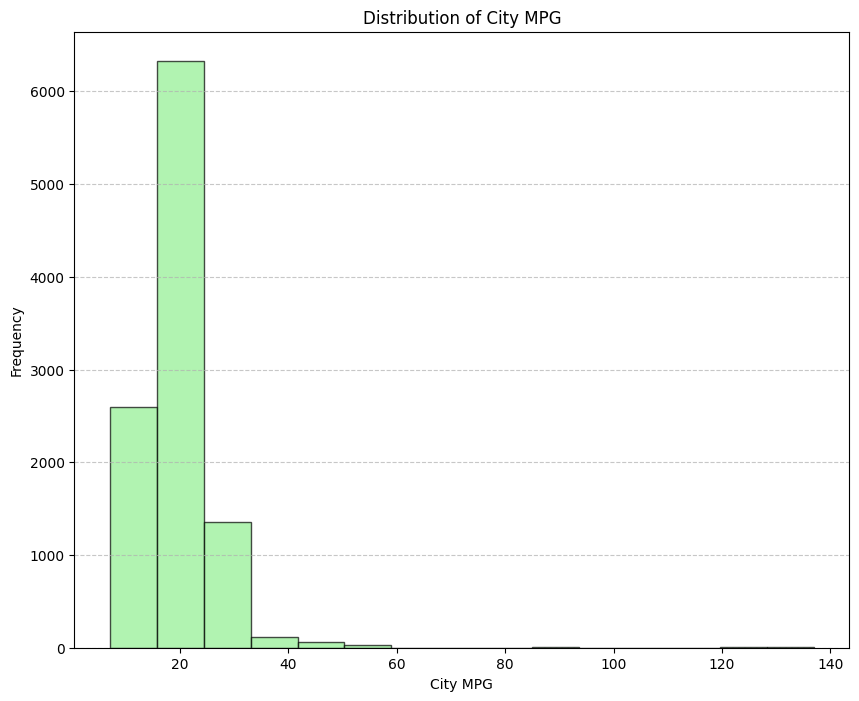

In [ ]:
# histogram for city mpg

plt.figure(figsize=(10,8))
plt.hist(filtered_df["city mpg"], bins=15, edgecolor='black', alpha=0.7, color='lightgreen')

plt.xlabel("City MPG")
plt.ylabel("Frequency")
plt.title("Distribution of City MPG")

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

The data is skewed right, indicating that most cars tend towards having a lower fuel efficiency in the city. The center of the distribution leans towards just 20 Miles per Gallon. There are a few outliers that may warrant exploration.

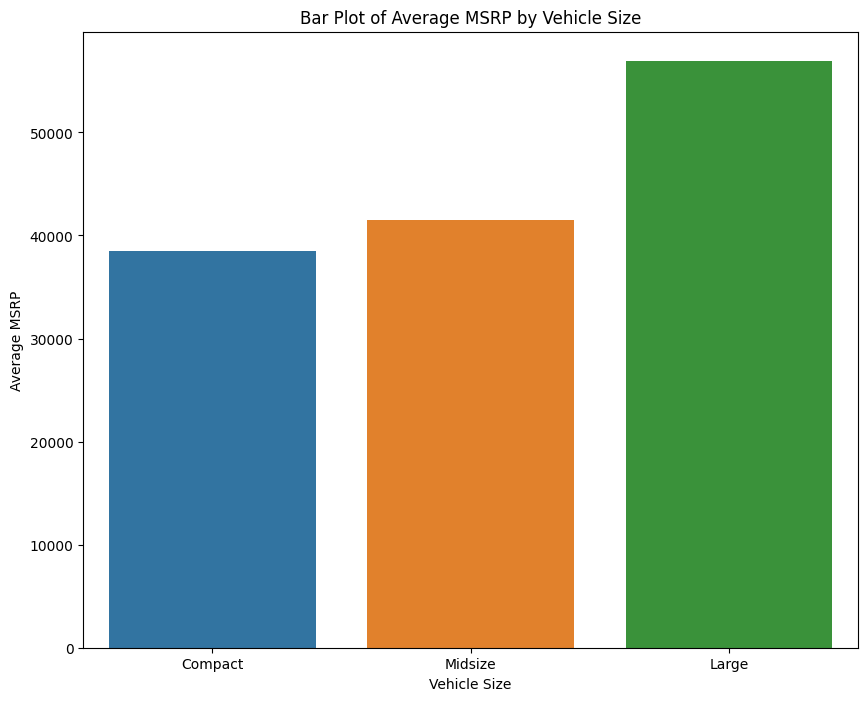

In [ ]:
# bar chart showing the average MSRP for each category in Vehicle Size.

plt.figure(figsize=(10,8))

sns.barplot(
    data=filtered_df,
    x="Vehicle Size",
    y="MSRP",
    hue="Vehicle Size",
    errorbar=None
)

plt.xlabel("Vehicle Size")
plt.ylabel("Average MSRP")
plt.title("Bar Plot of Average MSRP by Vehicle Size")

plt.show()


It seems that in general, the larger the vehicles get, the more expensive they are too.

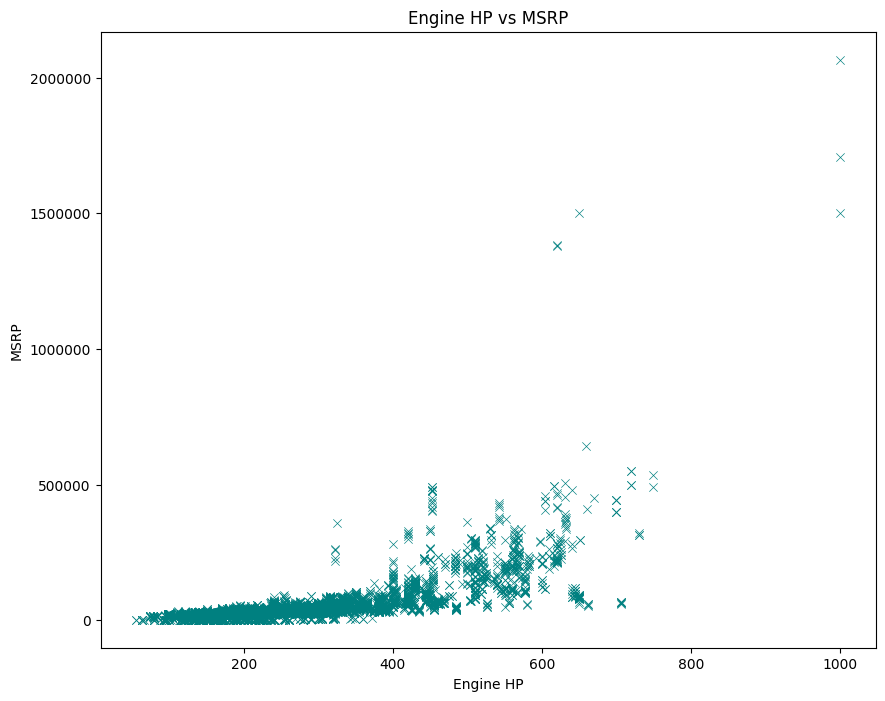

In [ ]:
# scatter plot showing the relationship between Engine HP and MSRP.

plt.figure(figsize=(10,8))
plt.ticklabel_format(style='plain')

sns.scatterplot(
        data=filtered_df,
        x='Engine HP',
        y='MSRP',
        color="teal",
        marker='x'
        )
plt.title('Engine HP vs MSRP')
plt.xlabel('Engine HP')
plt.ylabel('MSRP')
plt.show()

There is a general trend that the more Horsepower a vehicle has, the more expensive it becomes. However, there seem to be quite a few outliers and the much variance

In [ ]:
### I NOW REALIZE THIS IS WRONG BECAUSE I USED CHI-SQUARED ON CONTINUOUS DATA
### PEARSON CORRELATION WOULD BE BETTER, DONE LATER

contingency_table = pd.crosstab(filtered_df['Engine HP'], filtered_df['MSRP'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-Square Statistic:", chi2)
print("P-Value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies:\n", expected)

# Interpret results
if p < 0.05:
    print("Conclusion: There is a significant relationship between Engine HP and MSRP.")
else:
    print("Conclusion: There is no significant relationship between Engine HP and MSRP.")

Chi-Square Statistic: 2468295.4825538234
P-Value: 0.0
Degrees of Freedom: 2020620
Expected Frequencies:
 [[4.87479768e-02 1.90421784e-04 1.90421784e-04 ... 3.80843569e-04
  1.90421784e-04 1.90421784e-04]
 [1.46243930e-01 5.71265353e-04 5.71265353e-04 ... 1.14253071e-03
  5.71265353e-04 5.71265353e-04]
 [2.43739884e-02 9.52108921e-05 9.52108921e-05 ... 1.90421784e-04
  9.52108921e-05 9.52108921e-05]
 ...
 [7.31219652e-02 2.85632676e-04 2.85632676e-04 ... 5.71265353e-04
  2.85632676e-04 2.85632676e-04]
 [4.87479768e-02 1.90421784e-04 1.90421784e-04 ... 3.80843569e-04
  1.90421784e-04 1.90421784e-04]
 [7.31219652e-02 2.85632676e-04 2.85632676e-04 ... 5.71265353e-04
  2.85632676e-04 2.85632676e-04]]
Conclusion: There is a significant relationship between Engine HP and MSRP.


/tmp/ipython-input-95-2512380026.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


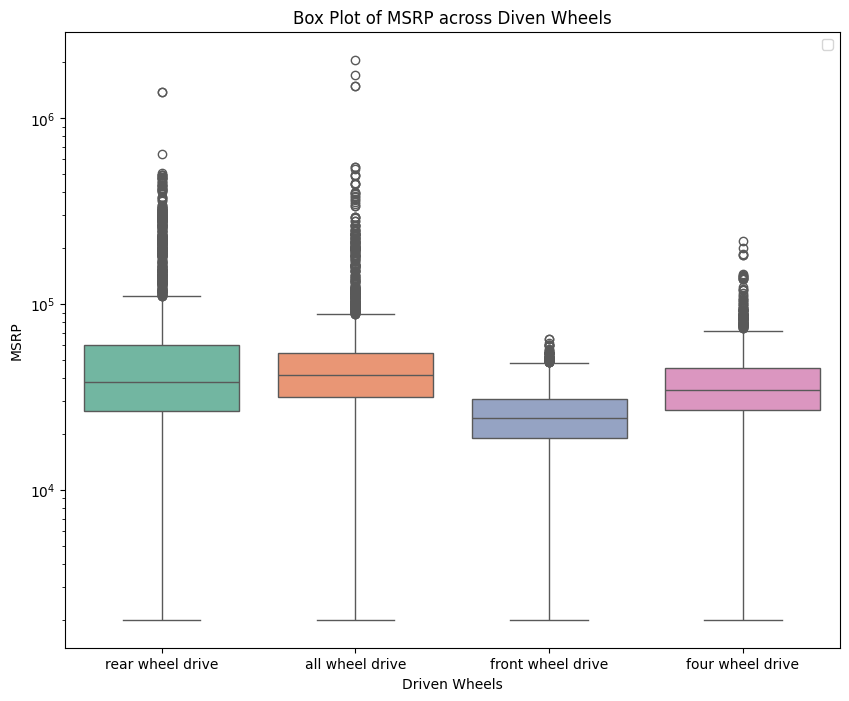

In [ ]:
# boxplot showing the distribution of MSRP for each category in Driven_Wheels.

plt.figure(figsize=(10,8))
plt.ticklabel_format(style='plain')

sns.boxplot(
    data=filtered_df,
    x='Driven_Wheels',
    y='MSRP',
    hue='Driven_Wheels',
    palette='Set2'
)

plt.title('Box Plot of MSRP across Diven Wheels')
plt.xlabel('Driven Wheels')
plt.ylabel('MSRP')
plt.yscale('log') # seems to be better readable with a logarithmic scale
plt.legend()

plt.show()

The central tendency of price for all the different drivetrains seem to be roughly in the same ballpark. The front wheel drive vehicles seem to be the cheapest vehicles in general with the tightest IQR, and lowest whiskers and outliers. The rear wheel drive vehicles have the widest IQR, which overlaps with all three other drivetrains.

However, data also indicates lots and lots of outliers, but mostly above the upper whisker. Could these be from luxury brands that are priced way above the rest of the population? And could these outliers be correlated with the records who are paying upwards of 2000 dollars per horsepower?

  Transmission Type    city mpg
0  AUTOMATED_MANUAL   20.425725
1         AUTOMATIC   18.973455
2      DIRECT_DRIVE  110.600000
3            MANUAL   19.903657
4           UNKNOWN   15.555556
  Transmission Type  highway MPG
0  AUTOMATED_MANUAL    28.898551
1         AUTOMATIC    25.817697
2      DIRECT_DRIVE    95.200000
3            MANUAL    27.292150
4           UNKNOWN    22.555556


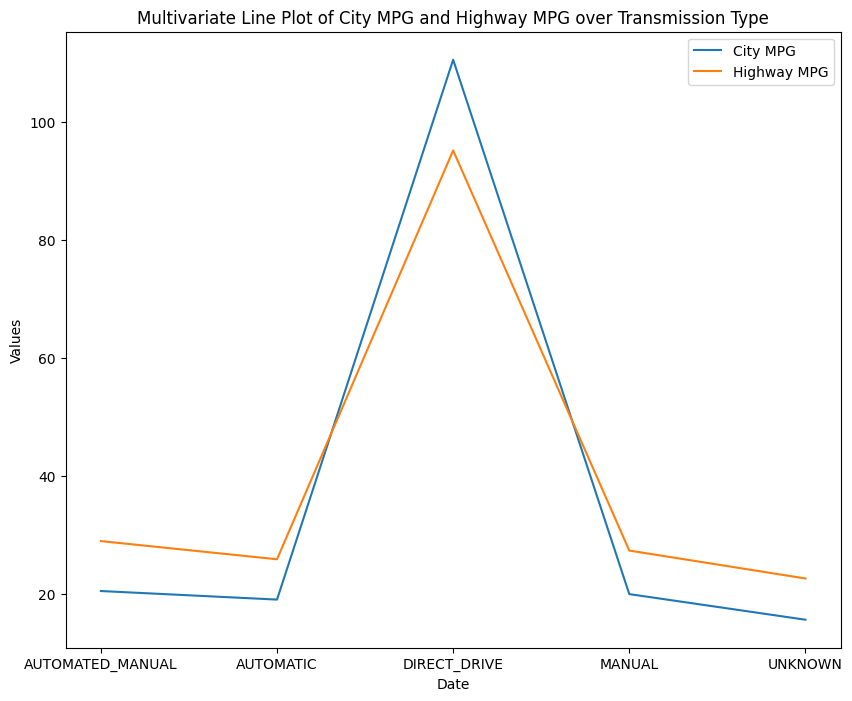

In [ ]:
# line plot showing trends in average city mpg and highway MPG for different Transmission Type.
plt.figure(figsize=(10,8))

avg_city_mpg = filtered_df.groupby("Transmission Type")["city mpg"].mean().reset_index()
print(avg_city_mpg)
avg_highway_mpg = filtered_df.groupby("Transmission Type")["highway MPG"].mean().reset_index()
print(avg_highway_mpg)

plt.plot(avg_city_mpg['Transmission Type'],
         avg_city_mpg["city mpg"], label='City MPG')
plt.plot(avg_highway_mpg['Transmission Type'],
         avg_highway_mpg["highway MPG"], label='Highway MPG')

plt.title('Multivariate Line Plot of City MPG and Highway MPG over Transmission Type')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()

In general, fuel efficiency seems to be the highest for direct drive vehicles i.e. electric vehicles. Not counting vehicles where the transmission is unknown, Automatic vehicles seem to have the poorest fuel efficiency, whether in the city or on the highway, while the manual transmisssion and automated manual transmission drive trains have similar performance.

# Correlations

In [ ]:
#Engine HP, MSRP, Popularity, city mpg, and highway MPG.
filtered_df.head()

numeric_df = filtered_df[["Engine HP", 'MSRP', 'Popularity',
                          'city mpg', 'highway MPG']]
print(filtered_df.shape, numeric_df.shape)
numeric_df.head()



(10503, 18) (10503, 5)


,Engine HP,MSRP,Popularity,city mpg,highway MPG
0,335.0,46135,3916,19,26
1,300.0,40650,3916,19,28
2,300.0,36350,3916,20,28
3,230.0,29450,3916,18,28
4,230.0,34500,3916,18,28


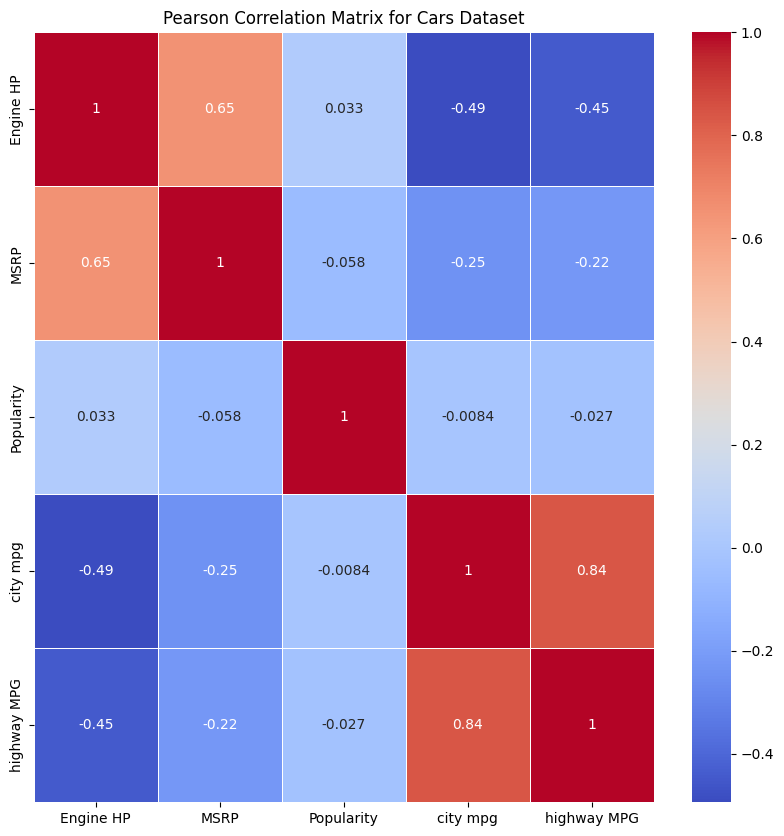

In [ ]:
correlation_matrix = numeric_df.corr(method='pearson')

plt.figure(figsize=(10,10))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    linewidths=0.5
)

plt.title('Pearson Correlation Matrix for Cars Dataset')
plt.show()

#confirmation of Engine HP and MSRP correlation

There seems to be a strong positive correlation between `city mpg` and `highway MPG`, and a moderate positive correlation between `MSRP` and `Engine HP`. These make sense because:
- it is the same engine that runs in the highway or in the city, and more efficient engines in would generally perform better than the less efficient engines, whether in the city or on the highway.
- Anecdotally, we know that fastest cars are also branded as luxury or sports cars. Marketing for cars also emphasize speed (e.g. 0 - 60MPH in 2 seconds), and so cars with more horsepower would tend to command a higher price.

On the flip side, there seems to be a moderate negative correlation between `Engine HP` and `city mpg`, which means there would also be a moderate negative correlation between `Engine HP` and `highway MPG`. These negative correlations with the MPG metrics are also visible but more weakly with `MSRP`. This also makes sense because:
- The more Horsepower an engine has, the more fuel it needs to consume for the distance it needs to travel, hence leading to lower fuel efficiency.
- Since the more expensive cars have higher horsepower, they would also tend to be less fuel efficient.


# Summary

**Cleaned Dataset**: filtered_df

**Summmary of Observations**:


*   Standard Deviation of Horsepower, Popularity, and MSRP seems quite high. Their min and max values are also quite far apart. This warrants a look at the outliers.
*   There were engines with 0 cylinders which looked funny to me. Upon inspection, they were electric vehicles, which made sense.
*   The most expensive combination (Driven_Wheels, Vehicle Size,  Engine Cylinders) is All Wheel Drive, Compact, with 16.0 cylinders.
*   The least expensive combination (Driven_Wheels, Vehicle Size,  Engine Cylinders)
is Front Weel Drive, Midsize, 5.0 Cylinders.
*   The most popular combination (Driven_Wheels, Vehicle Size,  Engine Cylinders) is Rear Wheel Drive, Compact, 0.0 Cylinders i.e. electric.
*   The least popular combination (Driven_Wheels, Vehicle Size,  Engine Cylinders) is Four Wheel Drive, Midsize, 5.0 Cylinders.
*   The data on City MPG is skewed right, indicating that most cars tend towards having a lower fuel efficiency in the city. The center of the distribution leans towards just 20 Miles per Gallon. There are a few outliers that may warrant exploration.
*   It seems that in general, the larger the vehicles get, the more expensive they are too.
*   There is a general trend that the more Horsepower a vehicle has, the more expensive it becomes. However, there seem to be quite a few outliers and the much variance just based on my eye test. The chi-square test done afterwards confirms that there's a significant relationship.
*   The central tendency of price for all the different drivetrains seem to be roughly in the same ballpark. The front wheel drive vehicles seem to be the cheapest vehicles in general with the tightest IQR, and lowest whiskers and outliers. The rear wheel drive vehicles have the widest IQR, which overlaps with all three other drivetrains.
*   However, data also indicates lots and lots of outliers, but mostly above the upper whisker. Could these be from luxury brands that are priced way above the rest of the popuulation?
*   In general, fuel efficiency seems to be the highest for direct drive vehicles. Automatic vehicles seem to have the poorest fuel efficiency, whether in the city or on the highway, while the manual transmisssion and automated manual transmission drive trains have similar performance.


Correlations
* There seems to be a strong positive correlation between `city mpg` and `highway MPG`, and a moderate positive correlation between `MSRP` and `Engine HP`. These make sense because:
  * It is the same engine that runs in the highway or in the city, and more efficient engines in would generally perform better than the less efficient engines, whether in the city or on the highway.
  * Anecdotally, we know that fastest cars are also branded as luxury or sports cars. Marketing for cars also emphasize speed (e.g. 0 - 60MPH in 2 seconds), and so cars with more horsepower would tend to command a higher price.
* On the flip side, there seems to be a moderate negative correlation between `Engine HP` and `city mpg`, which means there would also be a moderate negative correlation between `Engine HP` and `highway MPG`. These negative correlations with the MPG metrics are also visible but more weakly with `MSRP`. This also makes sense because:
  * The more Horsepower an engine has, the more fuel it needs to consume for the distance it needs to travel, hence leading to lower fuel efficiency.
  * Since the more expensive cars have higher horsepower, they would also tend to be less fuel efficient.

